<a href="https://colab.research.google.com/github/HassanRehanMemon/Deep-Learning/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT and Constants

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [ ]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10


SEQ_LENGTH = 300

BATCH_SIZE = 1024
epochs = 8


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Data Collection and Cleaning

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/twitter/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [ ]:
data.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
decoder_map = {0:'Positive', 2: 'Neutral', 4:'Negative'}
def decode_targets(target):
  return decoder_map[int(target)]

data['target'] = data['target'].apply(decode_targets)

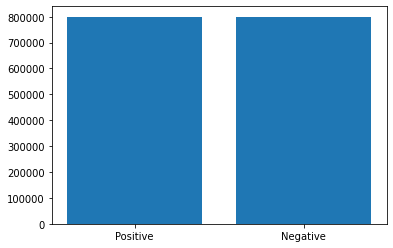

In [ ]:
targets = Counter(data['target'])
plt.bar(targets.keys(), targets.values())
plt.show()

In [ ]:
stop_words =  stopwords.words("english")

In [ ]:
print(len(stop_words))
print('Some Stop Words',str(stop_words[:10]))

179
Some Stop Words ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [ ]:
def clean_text(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
data['text'] = data.text.apply(lambda x: clean_text(x))

In [ ]:
data.head(5)

,target,ids,date,flag,user,text
0,Positive,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,Positive,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,Positive,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,Positive,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Positive,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [ ]:
trainDf, testDf = train_test_split(data, test_size= 0.2, random_state=42)

In [ ]:
print('train, test =', len(trainDf), len(testDf))

train, test = 1280000 320000


### Word2Vec

In [ ]:
# Saved model after training
w2vModel = gensim.models.word2vec.Word2Vec.load('/content/drive/MyDrive/twitter/word2vec.model')

In [ ]:
w2vModel = gensim.models.word2vec.Word2Vec(
    size= W2V_SIZE,
    window=W2V_WINDOW,
    min_count = W2V_MIN_COUNT,
    workers=8
)

In [ ]:
documents = [_text.split() for _text in trainDf.text]

In [ ]:
w2vModel.build_vocab(documents)

In [ ]:
words = w2vModel.wv.vocab.keys()

In [ ]:
print('vocab_size :', len(words))
print(list(itertools.islice(words, 10)))

vocab_size : 30369
['ya', 'quot', 'like', 'palm', 'pre', 'charger', 'yes', 'sounds', 'good', 'beer']


In [ ]:
for i, word in enumerate(words):
  print(word,'\t', w2vModel.wv.vocab[word])
  if i >= 10:
    break 

ya 	 Vocab(count:8715, index:163, sample_int:4294967296)
quot 	 Vocab(count:57678, index:5, sample_int:2329646646)
like 	 Vocab(count:62879, index:3, sample_int:2204761709)
palm 	 Vocab(count:493, index:2253, sample_int:4294967296)
pre 	 Vocab(count:1129, index:1145, sample_int:4294967296)
charger 	 Vocab(count:468, index:2362, sample_int:4294967296)
yes 	 Vocab(count:14883, index:74, sample_int:4294967296)
sounds 	 Vocab(count:7032, index:211, sample_int:4294967296)
good 	 Vocab(count:72990, index:0, sample_int:2006369529)
beer 	 Vocab(count:2023, index:711, sample_int:4294967296)
ready 	 Vocab(count:11186, index:117, sample_int:4294967296)


In [ ]:
w2vModel.train(documents, total_examples=len(documents), epochs= W2V_EPOCH)

(263125723, 295270528)

In [ ]:
w2vModel.save("/content/drive/MyDrive/twitter/word2vec.model")

In [ ]:
w2vModel.wv.word_vec('ya').shape

(300,)

In [ ]:
for i, word in enumerate(words):
  print(word,'\t', w2vModel.wv.vocab[word])
  if i >= 10:
    break 

ya 	 Vocab(count:8715, index:163, sample_int:4294967296)
quot 	 Vocab(count:57678, index:5, sample_int:2329646646)
like 	 Vocab(count:62879, index:3, sample_int:2204761709)
palm 	 Vocab(count:493, index:2253, sample_int:4294967296)
pre 	 Vocab(count:1129, index:1145, sample_int:4294967296)
charger 	 Vocab(count:468, index:2362, sample_int:4294967296)
yes 	 Vocab(count:14883, index:74, sample_int:4294967296)
sounds 	 Vocab(count:7032, index:211, sample_int:4294967296)
good 	 Vocab(count:72990, index:0, sample_int:2006369529)
beer 	 Vocab(count:2023, index:711, sample_int:4294967296)
ready 	 Vocab(count:11186, index:117, sample_int:4294967296)


In [ ]:
w2vModel.similar_by_word('like')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('liek', 0.5212579369544983),
 ('weird', 0.4627820551395416),
 ('bad', 0.4473360776901245),
 ('inadequate', 0.4237218499183655),
 ('better', 0.4065791368484497),
 ('different', 0.38669127225875854),
 ('odd', 0.38525259494781494),
 ('stalkerish', 0.38217806816101074),
 ('pathetic', 0.3808736801147461),
 ('mean', 0.3781347870826721)]

## Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(trainDf.text)

vocab_size = len(tokenizer.word_index) +1
print('vocab_size', vocab_size)

vocab_size 290419


In [ ]:
# print(tokenizer.document_count)
for i, ( word, idx) in enumerate(tokenizer.word_index.items()):
  print(word, idx, w2vModel.wv.vocab[word], sep='\t\t')
  if i >15:
    break

print('-'*100)
for  w in trainDf.text[0].split():
  print(w, tokenizer.word_index[w], w2vModel.wv.vocab[w], sep='\t\t')



good		1		Vocab(count:72990, index:0, sample_int:2006369529)
day		2		Vocab(count:69741, index:1, sample_int:2064744927)
get		3		Vocab(count:65663, index:2, sample_int:2144939496)
like		4		Vocab(count:62879, index:3, sample_int:2204761709)
go		5		Vocab(count:59254, index:4, sample_int:2289819836)
quot		6		Vocab(count:57678, index:5, sample_int:2329646646)
today		7		Vocab(count:54521, index:6, sample_int:2415342673)
work		8		Vocab(count:52012, index:7, sample_int:2489793525)
going		9		Vocab(count:51775, index:8, sample_int:2497146958)
love		10		Vocab(count:51769, index:9, sample_int:2497333875)
got		11		Vocab(count:49114, index:10, sample_int:2583895173)
lol		12		Vocab(count:47353, index:11, sample_int:2645910882)
time		13		Vocab(count:46341, index:12, sample_int:2683388847)
back		14		Vocab(count:45483, index:13, sample_int:2716292417)
u		15		Vocab(count:44729, index:14, sample_int:2746108976)
one		16		Vocab(count:43132, index:15, sample_int:2812236390)
know		17		Vocab(count:41710, index:

In [ ]:
word = 'third'
print(word,  tokenizer.word_index[word], w2vModel.wv.vocab[word], sep='\t\t')

third		1807		Vocab(count:654, index:1806, sample_int:4294967296)


In [ ]:
print(trainDf.text[0] )
print(tokenizer.texts_to_sequences([trainDf.text[0]]))

awww bummer shoulda got david carr third day
[[346, 1065, 3377, 11, 723, 9396, 1807, 2]]


### Embedding Matrix

In [ ]:
emb_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, idx in tokenizer.word_index.items():
  if word in w2vModel.wv:
    emb_matrix[idx] = w2vModel.wv[word]

print(emb_matrix.shape)

(290419, 300)


## X,Y train & test

In [ ]:
xTrain = pad_sequences(tokenizer.texts_to_sequences(trainDf.text), maxlen=SEQ_LENGTH)
xTest = pad_sequences(tokenizer.texts_to_sequences(testDf.text), maxlen=SEQ_LENGTH)

In [ ]:
encoder = LabelEncoder()
encoder.fit(trainDf.target.tolist())

yTrain = encoder.transform(trainDf.target.tolist()).reshape(-1,1)
yTest = encoder.transform(testDf.target.tolist()).reshape(-1,1)

In [ ]:
print('yTrain', yTrain.shape)
print('yTest', yTest.shape)
print('xTrain', xTrain.shape)
print('xTest', xTest.shape)

yTrain (1280000, 1)
yTest (320000, 1)
xTrain (1280000, 300)
xTest (320000, 300)


## Model

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, input_length=SEQ_LENGTH, weights=[emb_matrix] )

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 87,286,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [ ]:
import keras
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 2 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save("/content/drive/MyDrive/twitter/model_{}.hd5".format(epoch))

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5),
             CustomSaver()
             ]

In [ ]:
history = model.fit(
    xTrain, yTrain, BATCH_SIZE, epochs, validation_split=0.1, callbacks=callbacks, verbose=1, initial_epoch=4
)

In [ ]:

model.save('/content/drive/MyDrive/twitter/MainModel8.h5')

In [ ]:
import keras
model = keras.models.load_model('/content/drive/MyDrive/twitter/MainModel8.h5')
w2vModel = gensim.models.word2vec.Word2Vec.load('/content/drive/MyDrive/twitter/word2vec.model')

In [ ]:
score = model.evaluate(xTest, yTest, batch_size=BATCH_SIZE)

print("ACCURACY:",score[1])
print("LOSS:",score[0])


313/313 [==============================] - 836s 3s/step - loss: 0.5072 - accuracy: 0.7849
ACCURACY: 0.7849125266075134
LOSS: 0.5072051286697388


In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = 'Postive' if score < 0.5 else 'Negative'

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love rain")

{'elapsed_time': 0.10013508796691895,
 'label': 'Postive',
 'score': 0.14476332068443298}

In [ ]:
predict('NLP is easy')

{'elapsed_time': 0.10351204872131348,
 'label': 'Postive',
 'score': 0.08874425292015076}

In [ ]:
predict('the food was expire')

{'elapsed_time': 0.09786510467529297,
 'label': 'Negative',
 'score': 0.9577356576919556}

In [ ]:
predict("this game is boring")

{'elapsed_time': 0.10500097274780273,
 'label': 'Negative',
 'score': 0.9197648167610168}

In [ ]:
pickle.dump(tokenizer, open('/content/drive/MyDrive/twitter/tokenizer.pkl', "wb"), protocol=0)